# Детекция объектов VOC2012 (Faster RCNN)

## Импорт библиотек

In [28]:
# Для загрузки и анализа данных
import os
import tarfile
import urllib.request
import glob
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn import preprocessing
from time import time

# Для работы с изображениями
import torchvision
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torchvision.ops.boxes import nms
import torchvision.transforms.v2 as TV2
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from IPython.display import display

# Для построения модели
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

## Загрузка данных

Будем использовать набор данных PASCAL Visual Object Classes ([VOC](http://host.robots.ox.ac.uk/pascal/VOC/index.html)), в котором присутствует 20 классов изображений.

In [2]:
# Загрузка датасета
if not os.path.exists("VOCdevkit"):
    if not os.path.exists("VOC.tar"):
        urllib.request.urlretrieve(
            "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar",
            "VOC.tar"
        )
    with tarfile.open("VOC.tar") as tar:
        tar.extractall()

Экспортируем информацию из аннотаций с помощью функции `xml_to_csv`.

In [12]:
# Путь до папки с датасетом
DATASET_PATH = "/kaggle/working/VOCdevkit/VOC2012"
# Путь до папки с аннотациями
ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "Annotations")
# Путь до папки с изображениями
IMAGES_PATH = os.path.join(DATASET_PATH, "JPEGImages")

# Функция для парсинга xml-файлов
def xml_to_csv(path=ANNOTATIONS_PATH):
    xml_list = []
    for xml_file in tqdm(glob.glob(path + '/2010*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for obj in root.findall('object'):
            bbx = obj.find('bndbox')
            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            name = obj.find('name').text

            value = (root.find('filename').text,
                     width, height, name,
                     xmin, ymin, xmax, ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'name', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

Сохраним полученную информацию в VOC_2010.csv файл.

In [13]:
xml_df = xml_to_csv()
xml_df.to_csv('VOC_2010.csv', index=None)
print('Successfully converted xml to csv.')

100%|██████████| 3503/3503 [00:00<00:00, 10245.13it/s]

Successfully converted xml to csv.


In [14]:
xml_df.head()

,filename,width,height,name,xmin,ymin,xmax,ymax
0,2010_001134.jpg,500,333,pottedplant,38,244,186,333
1,2010_001134.jpg,500,333,pottedplant,260,169,497,333
2,2010_001134.jpg,500,333,pottedplant,417,1,500,82
3,2010_001134.jpg,500,333,pottedplant,300,26,467,193
4,2010_001134.jpg,500,333,pottedplant,158,94,323,260


In [15]:
print(f'Общее количество объектов {xml_df.shape[0]}')
print(f'Количество изображений в датафрэйме {len(np.unique(xml_df["filename"]))}')

Общее количество объектов 7760
Количество изображений в датафрэйме 3503


## Обработка данных

Закодируем классы обьектов.

In [16]:
le = preprocessing.LabelEncoder()
xml_df['class'] = le.fit_transform(xml_df['name'])

xml_df.head()

,filename,width,height,name,xmin,ymin,xmax,ymax,class
0,2010_001134.jpg,500,333,pottedplant,38,244,186,333,15
1,2010_001134.jpg,500,333,pottedplant,260,169,497,333,15
2,2010_001134.jpg,500,333,pottedplant,417,1,500,82,15
3,2010_001134.jpg,500,333,pottedplant,300,26,467,193,15
4,2010_001134.jpg,500,333,pottedplant,158,94,323,260,15


In [17]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))
labels_dict = dict(zip(mapping.values(), mapping.keys()))
labels_dict

{0: 'aeroplane',
 1: 'bicycle',
 2: 'bird',
 3: 'boat',
 4: 'bottle',
 5: 'bus',
 6: 'car',
 7: 'cat',
 8: 'chair',
 9: 'cow',
 10: 'diningtable',
 11: 'dog',
 12: 'horse',
 13: 'motorbike',
 14: 'person',
 15: 'pottedplant',
 16: 'sheep',
 17: 'sofa',
 18: 'train',
 19: 'tvmonitor'}

## Формируем датасет

Разделим выборку на train и val.

In [18]:
image_ids = xml_df['filename'].unique()
train_ids = image_ids[0:int(0.8*len(image_ids))]
valid_ids = image_ids[int(0.8*len(image_ids)):]
print(f'Число изображений: {len(image_ids)}')
print(f'Объем train выборки: {len(train_ids)}')
print(f'Объем valid выборки: {len(valid_ids)}')

Число изображений: 3503
Объем train выборки: 2802
Объем valid выборки: 701


In [19]:
train_df = xml_df[xml_df['filename'].isin(train_ids)]
valid_df = xml_df[xml_df['filename'].isin(valid_ids)]

Вспомогательная функция для аугментации данных.

In [25]:
def get_transforms(phase):
    list_transforms = []
    if phase == 'train':
        list_transforms.extend([
            A.Flip(p=0.5),
            A.RandomBrightnessContrast(p=0.5)
            ])
    list_transforms.extend([ToTensorV2(),])
    list_trms = A.Compose(
        list_transforms,
        bbox_params={'format': 'pascal_voc', 'label_fields':['labels']}
    )

    return list_trms

Напишем класс `VOC_2010()` для загрузки данных в модель.

In [26]:
class VOC_2010(Dataset):
    def __init__(self, df, image_dir, phase='train'):
        super().__init__()
        self.df = df
        self.image_dir = image_dir
        self.images = df['filename'].unique()
        self.transforms = get_transforms(phase)


    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        image = self.images[idx]
        image_id = str(image.split('.')[0])

        image_arr = cv2.imread(os.path.join(self.image_dir, image), cv2.IMREAD_COLOR)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)

        # Нормализация данных
        image_arr /= 255.0

        point = self.df[self.df['filename'] == image]
        boxes = point[['xmin', 'ymin', 'xmax', 'ymax']].values

        # Площадь внутри bbox
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # Запишем класс объекта в переменную label
        labels = torch.as_tensor(point['class'].values, dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor(idx)
        target['area'] = area

        if self.transforms:
            sample = {
                'image': image_arr,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']

        target['boxes'] = torch.stack(
            tuple(map(torch.tensor, zip(*sample['bboxes'])))
        ).permute(1, 0)

        return image, target, image_id


In [29]:
train_data = VOC_2010(train_df, IMAGES_PATH, phase='train')
valid_data = VOC_2010(valid_df, IMAGES_PATH, phase='validation')

print(f'Размер обучающей выборки {len(train_data)}')
print(f'Размер валидационной выборки {len(valid_data)}')

Размер обучающей выборки 2802
Размер валидационной выборки 701


In [30]:
BATCH_SIZE = 4

def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

## Визуализация данных

In [200]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data, idx):
    plt.figure(figsize=(10, 8))
    img = data.__getitem__(idx)
    image = image_convert(img[0])
    label = img[1]
    image = np.ascontiguousarray(image)
    bbox = img[1]['boxes']
    BOX_COLOR = (0, 255, 0)

    for j, box in enumerate(bbox):
        class_name = labels_dict[img[1]['labels'][j].item()]
        cv2.rectangle(
            image, (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            BOX_COLOR, thickness=1
            )
        ((text_width, text_height), _) = cv2.getTextSize(
            class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1
            )
        cv2.rectangle(
            image, (int(box[0]), int(box[1]) - int(1.3 * text_height)),
            (int(box[0]) + text_width, int(box[1])), BOX_COLOR, -1
            )
        cv2.putText(
            image,
            text=class_name,
            org=(int(box[0]), int(box[1]) - int(0.3 * text_height)),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.35,
            color=(255, 255, 255),
            lineType=cv2.LINE_AA,
        )
    plt.imshow(image)
    plt.show()

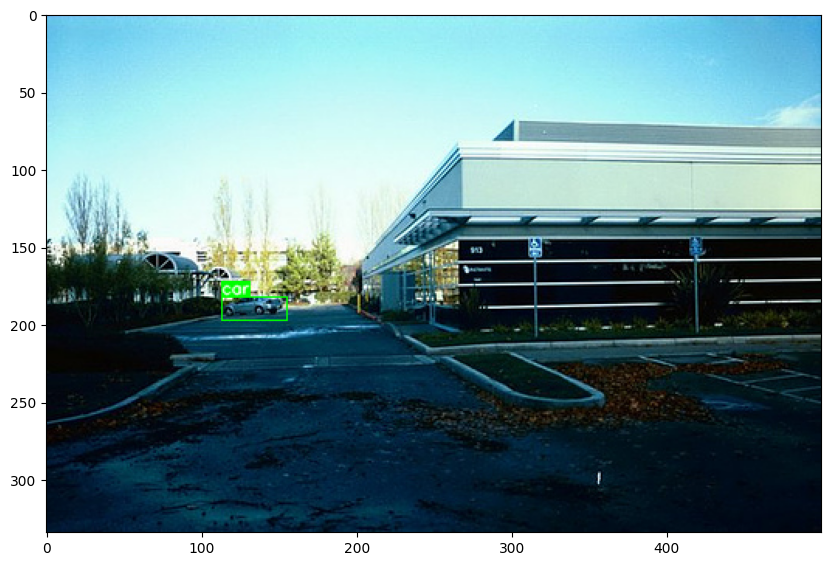

In [201]:
# Выберем рандомный индекс и выведем
# преобразованное изображение из датасета
random_image_idx = np.random.choice(range(len(train_data)))
plot_img(train_data, random_image_idx)

## Загрузка модели

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda


Загружаем предобученную модель.

In [221]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1')

In [222]:
num_classes = len(np.unique(xml_df['class']))
print(f'Число классов: {num_classes}')

# Получим число входных признаков для классификатора
in_features = model.roi_heads.box_predictor.cls_score.in_features

print(model.roi_heads)
# Заменим классификатор на новый
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
print(model.roi_heads)

Число классов: 20
RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
)
RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=20, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=80, bias=True)
  )
)


In [223]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-4, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

Напишем функции для тренировки и валидации модели. Единственным отличием между ними будет отсутствие расчета градиента при валидации.Внутри функций мы переводим все данные внутри бача на устройство, на котором будут производится расчеты. Затем подаем полученные тензоры в модель и получаем словарь со значениями функций потерь. После этого посчитаем их сумму и для удобства запишем ее в переменную running_loss для отслеживания прогресса обучения. В конце каждой эпохи будем выводить среднее значение функций потерь.

In [224]:
def train(train_dataloader, rep_freq=10):
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()
        losses.backward()
        optimizer.step()
        if i % rep_freq == 0:
            print(f"\tИтерация #{i} losses: {losses}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(valid_dataloader):
    running_loss = 0
    for data in valid_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()
    val_loss = running_loss/len(valid_dataloader.dataset)
    return val_loss

## Обучение

Начинаем обучение. Создадим два списка, куда будем сохранять значения функций потерь после каждой эпохи на тренировке и валидации

In [225]:
NUM_EPOCHS = 10
REP_FREQ = 100

train_losses = []
val_losses = []
try:
    for epoch in range(NUM_EPOCHS):
        start = time()
        train_loss = train(train_data_loader, rep_freq=REP_FREQ)
        val_loss = val(valid_data_loader)
        scheduler.step()
        print(f"Эпоха #{epoch + 1} train_loss: {train_loss}, val_loss: {val_loss}")
        end = time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch + 1} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
except KeyboardInterrupt:
    print('Прервано пользователем')

	Итерация #0 losses: 3.373674726109344
	Итерация #100 losses: 0.5537440981815867
	Итерация #200 losses: 0.4904789534409351
	Итерация #300 losses: 0.7565016768316154
	Итерация #400 losses: 0.24780527544326741
	Итерация #500 losses: 0.5469116558692854
	Итерация #600 losses: 0.588481393986737
	Итерация #700 losses: 0.41610893054836956
Эпоха #1 train_loss: 0.11327179744825235, val_loss: 0.10453281055103371
Потрачено 9.5 минут на 1 эпоху
	Итерация #0 losses: 0.7762411636454961
	Итерация #100 losses: 0.477986675702947
	Итерация #200 losses: 0.37773069824124583
	Итерация #300 losses: 0.7156115089965183
	Итерация #400 losses: 0.21888048571574234
	Итерация #500 losses: 0.5807373956380155
	Итерация #600 losses: 0.6163761962143987
	Итерация #700 losses: 0.4764846892590315
Эпоха #2 train_loss: 0.0983117624543392, val_loss: 0.09867313140348025
Потрачено 9.5 минут на 2 эпоху
	Итерация #0 losses: 0.7284680330567755
	Итерация #100 losses: 0.4353916712476377
	Итерация #200 losses: 0.37415730061399144
	

Визуализируем динамику лоссов

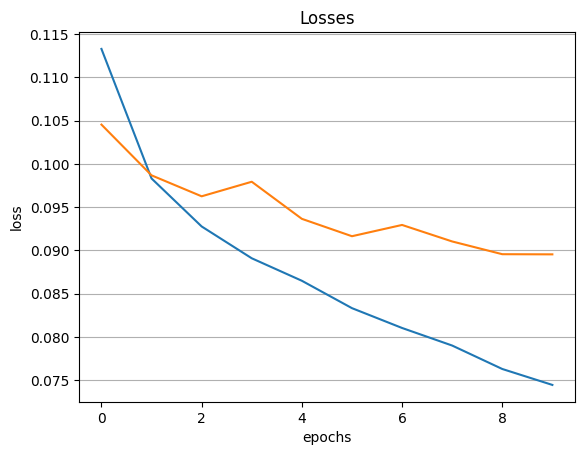

In [226]:
plt.title('Losses')
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(axis='y')
plt.show()

Обучение заняло полтора часа, а лоссы, как видим, все падали.

## Предсказание

In [227]:
def eval_fn(data_loader, model, device):
    model.eval()
    all_predictions = []

    with torch.no_grad():

        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            output = model(images)
        
            for i in range(len(images)):
                boxes = output[i]['boxes'].detach().cpu().numpy()
                labels = output[i]['labels'].detach().cpu().numpy()
                scores = output[i]['scores'].detach().cpu().numpy()

                all_predictions.append({
                    'pred_boxes': (boxes).astype(int),
                    'labels': (labels).astype(int),
                    'scores': scores,
                    'true_boxes': (targets[i]['boxes'].cpu().numpy()).astype(int),
                    'true_labels': (targets[i]['labels'].cpu().numpy()).astype(int),
                    'image_id': image_ids[i]
                })

    return all_predictions

In [228]:
all_predictions = eval_fn(valid_data_loader, model, device)

100%|██████████| 176/176 [00:56<00:00,  3.12it/s]


In [251]:
def draw_predict(idx, iou_threshold=0.5, threshold=0.15):
    img = image_convert(valid_data[idx][0])
    ind = nms(
        torch.from_numpy(all_predictions[idx]['pred_boxes']).to(dtype=torch.float32),
        torch.from_numpy(all_predictions[idx]['scores']).to(dtype=torch.float32),
        iou_threshold
        ).detach().cpu().numpy()
    for i, box in enumerate(all_predictions[idx]['pred_boxes'][ind]):
        label = labels_dict[all_predictions[idx]['labels'][i].item()]
        score = all_predictions[idx]['scores'][i]
        if all_predictions[0]['scores'][i] > threshold:
            cv2.rectangle(img,
                (int(box[0]), int(box[1])),
                (int(box[2]), int(box[3])),
                (255, 0, 0), thickness=1
            )
            ((text_width, text_height), _) = cv2.getTextSize(
                f"{label} {score:.2f}", cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1
            )
            cv2.rectangle(img,
                (int(box[0]), int(box[1]-3) - int(1.3 * text_height)),
                (int(box[0]) + text_width, int(box[1])), (255, 0, 0), -1
            )
            cv2.putText(img,
                text=f"{label} {score:.2f}",
                org=(int(box[0]), int(box[1])-3),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.35,
                color=(255, 255, 255),
                lineType=cv2.LINE_AA,
            )
    print(all_predictions[idx]['image_id'])
    plt.figure(figsize=(10, 8))
    plt.imshow(img)

2010_003361


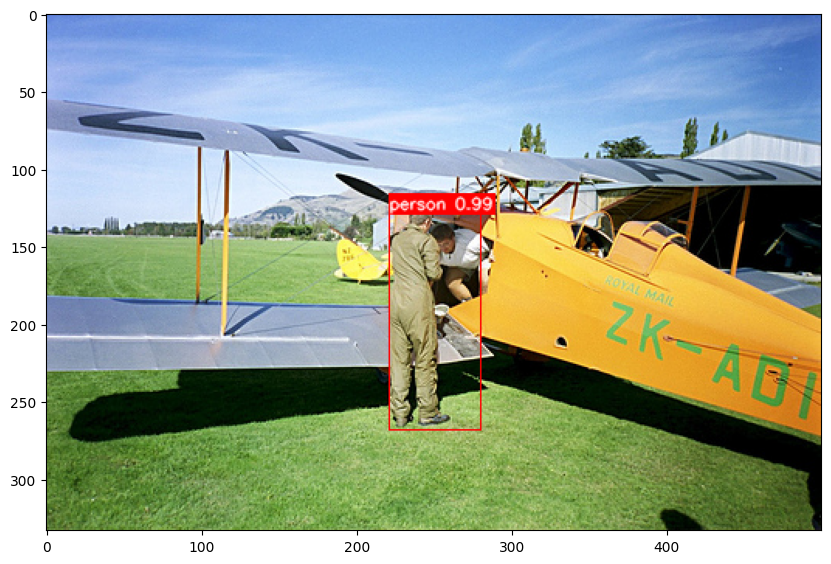

In [252]:
idx = 0
draw_predict(idx, iou_threshold=0.1, threshold=0.7)

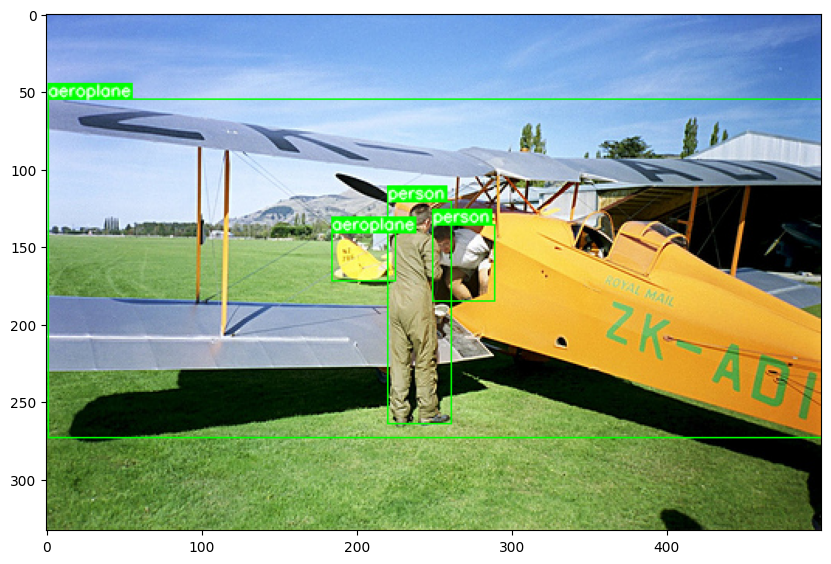

In [202]:
plot_img(valid_data, idx)

In [253]:
preds_rows = []
for entry in all_predictions:
    for i in range(len(entry['pred_boxes'])):
        preds_rows.append(
            [entry['pred_boxes'][i][0],
             entry['pred_boxes'][i][1],
             entry['pred_boxes'][i][2],
             entry['pred_boxes'][i][3],
             entry['labels'][i],
             labels_dict[entry['labels'][i]],
             entry['scores'][i],
             entry['image_id'] + '.jpg']
             )

preds_df = pd.DataFrame(
    preds_rows,
    columns=[
        'xmin', 'ymin', 'xmax', 'ymax',
        'class', 'name', 'scores', 'filename'
    ]
)


preds_df.head()

,xmin,ymin,xmax,ymax,class,name,scores,filename
0,221,129,280,268,14,person,0.987038,2010_003361.jpg
1,9,50,301,294,3,boat,0.619490,2010_003361.jpg
2,246,132,287,183,14,person,0.538443,2010_003361.jpg
3,5,69,253,212,3,boat,0.485535,2010_003361.jpg
4,0,74,339,267,18,train,0.472734,2010_003361.jpg


In [254]:
#Сохраняем полученные предсказания в виде таблицы
preds_df.to_csv('preds_df.csv', index=False)